# Nonstationary Convection-Diffusion Equation:

In [11]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import bicg, gmres

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Problem:

$\dfrac{\partial C}{\partial t}$
$+ \vec{b}\cdot \vec{\nabla} C $
$- \vec{\nabla}\cdot \mathscr{D}\vec{\nabla}C  = f(x, y, t)$


$ C\vert_{Г_D} = 0$, except for $C(0, y, t) = 1$, if $|y| <= 10$;

$\mathscr{D} = \begin{pmatrix} d_x & 0 \\ 0 & d_y \end{pmatrix}$;
$\vec{b} = (1, 0)$; $f(x, y, t) = 0$ in $\Omega$;  $C(x, y, 0) = 0$ in $int(\Omega)$; $d_y = 0.001$;

$\Omega = [0;200] \times [-100;100]$

$d_x = 0.0001 -> 1.0$

Task is to solve this equation with FEM and check for stability, and use SUPG if necessary.

In [12]:
class NCDE:
    """ Finite element method solver. """
    
    def __init__(self, T=50):
        """ T - number of time points we would like. """
        self.T = T
                             
        
    def _nnz(self):
        """
            Count the number of nonzero enrties in a matrix.
        """
        return 9 * self.n**2 - 12 * self.n + 4
    
                
    def _construct_matrix2(self, d_x=1e-4, n=32, supg=False):
        """
            Create sparse matrix for discretization, right side
            and extra matrix for calculations.
            Input parameters:
                - "d_x" - 1 -> 0.0001
                - "n" - size of 1d mesh
                - "supg" - on/off supg mode
        """
    
        self.n_mesh = n # initial size of 1-D mesh
        self.n = self.n_mesh - 2 # mesh for inner points 
        d_y = 1e-3 # fixed constant
        self.h = 200 / self.n_mesh # step through mesh
        self.dt = 50 / self.T # step through time
        
        p_e = self.h / d_x
        if (p_e >= 1.0) and supg:
            
            delta = (self.h - d_x) / 2
            self.A = {
                'center': (4 * self.h**2) / (9 * self.dt) + 0.0,
                'right': self.h**2 / (9 * self.dt) - (self.h * delta) / (3 * self.dt),
                'left': self.h**2 / (9 * self.dt) + (self.h * delta) / (3 * self.dt),
                'down': self.h**2 / (9 * self.dt) + 0.0,
                'up': self.h**2 / (9 * self.dt) + 0.0,
                'left_down': self.h**2 / (36 * self.dt) + (self.h * delta) / (12 * self.dt),
                'right_down': self.h**2 / (36 * self.dt) - (self.h * delta) / (12 * self.dt),
                'right_up': self.h**2 / (36 * self.dt) - (self.h * delta) / (12 * self.dt),
                'left_up': self.h**2 / (36 * self.dt) + (self.h * delta) / (12 * self.dt),
            }
        
            self.B = {
                'center': 4 * (d_x + d_y) / (3 * 2) + (4 * delta) / (3 * 2),
                'right': self.h / (3 * 2) + (-2 * d_x + d_y) / (3 * 2) - (2 * delta) / (3 * 2),
                'left': -self.h / (3 * 2) + (-2 * d_x + d_y) / (3 * 2) - (2 * delta) / (3 * 2),
                'down': (d_x - 2*d_y) / (3 * 2) + delta / (3 * 2),
                'up': (d_x - 2*d_y) / (3 * 2) + delta / (3 * 2),
                'left_down': -self.h / (12 * 2) - (d_x + d_y) / (6 * 2) - delta / (6 * 2),
                'right_down': self.h / (12 * 2) - (d_x + d_y) / (6 * 2) - delta / (6 * 2),
                'right_up': self.h / (12 * 2) - (d_x + d_y) / (6 * 2) - delta / (6 * 2),
                'left_up': -self.h / (12 * 2) - (d_x + d_y) / (6 * 2) - delta / (6 * 2),
            }
            
        else:
            
            self.A = {
                'center': (4 * self.h**2) / (9 * self.dt),
                'right': self.h**2 / (9 * self.dt),
                'left': self.h**2 / (9 * self.dt),
                'down': self.h**2 / (9 * self.dt) ,
                'up': self.h**2 / (9 * self.dt),
                'left_down': self.h**2 / (36 * self.dt),
                'right_down': self.h**2 / (36 * self.dt) ,
                'right_up': self.h**2 / (36 * self.dt),
                'left_up': self.h**2 / (36 * self.dt),
            }
        
            self.B = {
                'center': 4 * (d_x + d_y) / (3 * 2),
                'right': self.h / (3 * 2) + (-2 * d_x + d_y) / (3 * 2),
                'left': -self.h / (3 * 2) + (-2 * d_x + d_y) / (3 * 2),
                'down': (d_x - 2*d_y) / (3 * 2),
                'up': (d_x - 2*d_y) / (3 * 2),
                'left_down': -self.h / (12 * 2) - (d_x + d_y) / (6 * 2),
                'right_down': self.h / (12 * 2) - (d_x + d_y) / (6 * 2),
                'right_up': self.h / (12 * 2) - (d_x + d_y) / (6 * 2),
                'left_up': -self.h / (12 * 2) - (d_x + d_y) / (6 * 2),
            }
        
        nn = self.n**2 
        nnz = self._nnz()
        
        self.f = np.zeros(nn)
        self.a = np.empty(nnz) # values for sparse matrix
        self.ja = np.empty(nnz) # column indices for sparse matrix
        self.ia = np.empty(nn + 1) # row indices for sparse matrix 
        self.ia[0] = 0
        
        self.ra = np.empty(nnz) # values for sparse matrix
        self.jra = np.empty(nnz) # column indices for sparse matrix
        self.ira = np.empty(nn + 1) # row indices for sparse matrix 
        self.ira[0] = 0
        
        where_put = 0 # to iterate over arrays with values of matrix
        num_i = 0 # to moderate row/equation of a matrix
        
        for j in range(self.n):
            y_j = -100 + (j + 1) * self.h
            for i in range(self.n):
                x_i = (i + 1) * self.h
                
                if (i == 0) and (j == 0):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['right'] + self.B['right']
                    self.a[where_put + 2] = self.A['up'] + self.B['up']
                    self.a[where_put + 3] = self.A['right_up'] + self.B['right_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i + 1) + self.n * j
                    self.ja[where_put + 2] = i + self.n * (j + 1)
                    self.ja[where_put + 3] = (i + 1) + self.n * (j + 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 4
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['right'] - self.B['right']
                    self.ra[where_put + 2] = self.A['up'] - self.B['up']
                    self.ra[where_put + 3] = self.A['right_up'] - self.B['right_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i + 1) + self.n * j
                    self.jra[where_put + 2] = i + self.n * (j + 1)
                    self.jra[where_put + 3] = (i + 1) + self.n * (j + 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 4
                
                    where_put += 4
                    
                elif (i == 0) and (j == self.n - 1):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['right'] + self.B['right']
                    self.a[where_put + 2] = self.A['down'] + self.B['down']
                    self.a[where_put + 3] = self.A['right_down'] + self.B['right_down']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i + 1) + self.n * j
                    self.ja[where_put + 2] = i + self.n * (j - 1)
                    self.ja[where_put + 3] = (i + 1) + self.n * (j - 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 4
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['right'] - self.B['right']
                    self.ra[where_put + 2] = self.A['down'] - self.B['down']
                    self.ra[where_put + 3] = self.A['right_down'] - self.B['right_down']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i + 1) + self.n * j
                    self.jra[where_put + 2] = i + self.n * (j - 1)
                    self.jra[where_put + 3] = (i + 1) + self.n * (j - 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 4
                
                    where_put += 4
                
                elif (i == self.n - 1) and (j == 0):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['left'] + self.B['left']
                    self.a[where_put + 2] = self.A['up'] + self.B['up']
                    self.a[where_put + 3] = self.A['left_up'] + self.B['left_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i - 1) + self.n * j
                    self.ja[where_put + 2] = i + self.n * (j + 1)
                    self.ja[where_put + 3] = (i - 1) + self.n * (j + 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 4
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['left'] - self.B['left']
                    self.ra[where_put + 2] = self.A['up'] - self.B['up']
                    self.ra[where_put + 3] = self.A['left_up'] - self.B['left_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i - 1) + self.n * j
                    self.jra[where_put + 2] = i + self.n * (j + 1)
                    self.jra[where_put + 3] = (i - 1) + self.n * (j + 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 4
                
                    where_put += 4
                
                elif (i == self.n - 1) and (j == self.n - 1):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['left'] + self.B['left']
                    self.a[where_put + 2] = self.A['down'] + self.B['down']
                    self.a[where_put + 3] = self.A['left_down'] + self.B['left_down']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i - 1) + self.n * j
                    self.ja[where_put + 2] = i + self.n * (j - 1)
                    self.ja[where_put + 3] = (i - 1) + self.n * (j - 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 4
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['left'] - self.B['left']
                    self.ra[where_put + 2] = self.A['down'] - self.B['down']
                    self.ra[where_put + 3] = self.A['left_down'] - self.B['left_down']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i - 1) + self.n * j
                    self.jra[where_put + 2] = i + self.n * (j - 1)
                    self.jra[where_put + 3] = (i - 1) + self.n * (j - 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 4
                
                    where_put += 4
                
                elif (i == 0):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['down'] + self.B['down']
                    self.a[where_put + 2] = self.A['right'] + self.B['right']
                    self.a[where_put + 3] = self.A['up'] + self.B['up']
                    self.a[where_put + 4] = self.A['right_down'] + self.B['right_down']
                    self.a[where_put + 5] = self.A['right_up'] + self.B['right_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = i + self.n * (j - 1)
                    self.ja[where_put + 2] = (i + 1) + self.n * j 
                    self.ja[where_put + 3] = i + self.n * (j + 1)
                    self.ja[where_put + 4] = (i + 1) + self.n * (j - 1)
                    self.ja[where_put + 5] = (i + 1) + self.n * (j + 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 6
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['down'] - self.B['down']
                    self.ra[where_put + 2] = self.A['right'] - self.B['right']
                    self.ra[where_put + 3] = self.A['up'] - self.B['up']
                    self.ra[where_put + 4] = self.A['right_down'] - self.B['right_down']
                    self.ra[where_put + 5] = self.A['right_up'] - self.B['right_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = i + self.n * (j - 1)
                    self.jra[where_put + 2] = (i + 1) + self.n * j 
                    self.jra[where_put + 3] = i + self.n * (j + 1)
                    self.jra[where_put + 4] = (i + 1) + self.n * (j - 1)
                    self.jra[where_put + 5] = (i + 1) + self.n * (j + 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 6
                    where_put += 6
                    
                    if np.abs(y_j) < 10:
                        self.f[num_i] = -2 * (self.B['left'] + self.B['left_down'] + self.B['left_up'])
                        
                    elif y_j == 10.0:
                        self.f[num_i] = -2 * (self.B['left'] + self.B['left_up'])
                        
                    elif y_j == -10.0:
                        self.f[num_i] = -2 * (self.B['left'] + self.B['left_up'])
                        
                    else:    
                        self.f[num_i] = 0.0
                        
                elif (i == self.n - 1):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['down'] + self.B['down']
                    self.a[where_put + 2] = self.A['left'] + self.B['left']
                    self.a[where_put + 3] = self.A['up'] + self.B['up']
                    self.a[where_put + 4] = self.A['left_down'] + self.B['left_down']
                    self.a[where_put + 5] = self.A['left_up'] + self.B['left_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = i + self.n * (j - 1)
                    self.ja[where_put + 2] = (i - 1) + self.n * j 
                    self.ja[where_put + 3] = i + self.n * (j + 1)
                    self.ja[where_put + 4] = (i - 1) + self.n * (j - 1)
                    self.ja[where_put + 5] = (i - 1) + self.n * (j + 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 6
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['down'] - self.B['down']
                    self.ra[where_put + 2] = self.A['left'] - self.B['left']
                    self.ra[where_put + 3] = self.A['up'] - self.B['up']
                    self.ra[where_put + 4] = self.A['left_down'] - self.B['left_down']
                    self.ra[where_put + 5] = self.A['left_up'] - self.B['left_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = i + self.n * (j - 1)
                    self.jra[where_put + 2] = (i - 1) + self.n * j 
                    self.jra[where_put + 3] = i + self.n * (j + 1)
                    self.jra[where_put + 4] = (i - 1) + self.n * (j - 1)
                    self.jra[where_put + 5] = (i - 1) + self.n * (j + 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 6
                
                    where_put += 6
                
                elif (j == 0):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['left'] + self.B['left']
                    self.a[where_put + 2] = self.A['up'] + self.B['up']
                    self.a[where_put + 3] = self.A['right'] + self.B['right']
                    self.a[where_put + 4] = self.A['left_up'] + self.B['left_up']
                    self.a[where_put + 5] = self.A['right_up'] + self.B['right_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i - 1) + self.n * j 
                    self.ja[where_put + 2] = i + self.n * (j + 1) 
                    self.ja[where_put + 3] = (i + 1) + self.n * j 
                    self.ja[where_put + 4] = (i - 1) + self.n * (j + 1)
                    self.ja[where_put + 5] = (i + 1) + self.n * (j + 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 6
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['left'] - self.B['left']
                    self.ra[where_put + 2] = self.A['up'] - self.B['up']
                    self.ra[where_put + 3] = self.A['right'] - self.B['right']
                    self.ra[where_put + 4] = self.A['left_up'] - self.B['left_up']
                    self.ra[where_put + 5] = self.A['right_up'] - self.B['right_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i - 1) + self.n * j 
                    self.jra[where_put + 2] = i + self.n * (j + 1) 
                    self.jra[where_put + 3] = (i + 1) + self.n * j 
                    self.jra[where_put + 4] = (i - 1) + self.n * (j + 1)
                    self.jra[where_put + 5] = (i + 1) + self.n * (j + 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 6
                
                    where_put += 6
                
                elif (j == self.n - 1):
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['left'] + self.B['left']
                    self.a[where_put + 2] = self.A['down'] + self.B['down']
                    self.a[where_put + 3] = self.A['right'] + self.B['right']
                    self.a[where_put + 4] = self.A['left_down'] + self.B['left_down']
                    self.a[where_put + 5] = self.A['right_down'] + self.B['right_down']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i - 1) + self.n * j 
                    self.ja[where_put + 2] = i + self.n * (j - 1) 
                    self.ja[where_put + 3] = (i + 1) + self.n * j 
                    self.ja[where_put + 4] = (i - 1) + self.n * (j - 1)
                    self.ja[where_put + 5] = (i + 1) + self.n * (j - 1)
            
                    self.ia[num_i + 1] = self.ia[num_i] + 6
                
                
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['left'] - self.B['left']
                    self.ra[where_put + 2] = self.A['down'] - self.B['down']
                    self.ra[where_put + 3] = self.A['right'] - self.B['right']
                    self.ra[where_put + 4] = self.A['left_down'] - self.B['left_down']
                    self.ra[where_put + 5] = self.A['right_down'] - self.B['right_down']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i - 1) + self.n * j 
                    self.jra[where_put + 2] = i + self.n * (j - 1) 
                    self.jra[where_put + 3] = (i + 1) + self.n * j 
                    self.jra[where_put + 4] = (i - 1) + self.n * (j - 1)
                    self.jra[where_put + 5] = (i + 1) + self.n * (j - 1)
            
                    self.ira[num_i + 1] = self.ira[num_i] + 6
                
                    where_put += 6
                
                else:
                    
                    self.a[where_put] = self.A['center'] + self.B['center']
                    self.a[where_put + 1] = self.A['left'] + self.B['left']
                    self.a[where_put + 2] = self.A['right'] + self.B['right']
                    self.a[where_put + 3] = self.A['down'] + self.B['down']
                    self.a[where_put + 4] = self.A['up'] + self.B['up']
                    self.a[where_put + 5] = self.A['left_down'] + self.B['left_down']
                    self.a[where_put + 6] = self.A['right_down'] + self.B['right_down']
                    self.a[where_put + 7] = self.A['left_up'] + self.B['left_up']
                    self.a[where_put + 8] = self.A['right_up'] + self.B['right_up']
            
                    self.ja[where_put] = i + self.n * j
                    self.ja[where_put + 1] = (i - 1) + self.n * j 
                    self.ja[where_put + 2] = (i + 1) + self.n * j 
                    self.ja[where_put + 3] = i + self.n * (j - 1) 
                    self.ja[where_put + 4] = i + self.n * (j + 1)
                    self.ja[where_put + 5] = (i - 1) + self.n * (j - 1)
                    self.ja[where_put + 6] = (i + 1) + self.n * (j - 1)
                    self.ja[where_put + 7] = (i - 1) + self.n * (j + 1)
                    self.ja[where_put + 8] = (i + 1) + self.n * (j + 1)
        
                    self.ia[num_i + 1] = self.ia[num_i] + 9
            
            
                    self.ra[where_put] = self.A['center'] - self.B['center']
                    self.ra[where_put + 1] = self.A['left'] - self.B['left']
                    self.ra[where_put + 2] = self.A['right'] - self.B['right']
                    self.ra[where_put + 3] = self.A['down'] - self.B['down']
                    self.ra[where_put + 4] = self.A['up'] - self.B['up']
                    self.ra[where_put + 5] = self.A['left_down'] - self.B['left_down']
                    self.ra[where_put + 6] = self.A['right_down'] - self.B['right_down']
                    self.ra[where_put + 7] = self.A['left_up'] - self.B['left_up']
                    self.ra[where_put + 8] = self.A['right_up'] - self.B['right_up']
            
                    self.jra[where_put] = i + self.n * j
                    self.jra[where_put + 1] = (i - 1) + self.n * j 
                    self.jra[where_put + 2] = (i + 1) + self.n * j 
                    self.jra[where_put + 3] = i + self.n * (j - 1) 
                    self.jra[where_put + 4] = i + self.n * (j + 1)
                    self.jra[where_put + 5] = (i - 1) + self.n * (j - 1)
                    self.jra[where_put + 6] = (i + 1) + self.n * (j - 1)
                    self.jra[where_put + 7] = (i - 1) + self.n * (j + 1)
                    self.jra[where_put + 8] = (i + 1) + self.n * (j + 1)
        
                    self.ira[num_i + 1] = self.ira[num_i] + 9
                    where_put += 9
                num_i += 1   
                
    
    def solve(self, tol=1e-08, maxiter=100000):
        """
            Solve discretized system with BiCG.
            Input parameters:
                - "tol" - tolerence for the error
                - "maxiter" - needed to tune iterations properly
        """
        
        nn = self.n**2
        x_zero = np.zeros(nn)
        mtx = csr_matrix((self.a, self.ja, self.ia), shape=(nn, nn))
        rmtx = csr_matrix((self.ra, self.jra, self.ira), shape=(nn, nn))
        self.stack = x_zero
        
        for i in range(self.T):
            right = (rmtx @ x_zero) + self.f
            x_appr, info = bicg(mtx, right, x0=np.zeros(nn), tol=tol, maxiter=maxiter)
            self.stack = np.vstack((self.stack, x_appr))
            x_zero = x_appr.copy()
            
            if info > 0:
                print("Iterations number: ", info)
                self.iter = info
                return info

In [35]:
class Act:
    """ Better interface solver class """
       
    def act(self,
            solver, T=50,
            n=200, dx=1.0, supg=False, 
            tol=1e-08, maxiter=100000):
        
        """
            Use chosen solver class for SD problem.
            Input parameters:
                - "solver" - NCDE
                - "T" - number of 1d points in time
                - "n"- number of 1d points in space
                - "dx" - diffusion tensor parameter
                - "supg" - on/off supg mode
                - "tol" - used for solving SLE
                - "maxiter" - bound on iterations made(need for the task) 
        """
        
        self.model = solver(T=T)
        self.model._construct_matrix2(d_x=dx, n=n, supg=supg)
        self.model.solve(tol=tol, maxiter=maxiter)

    def __update(self, frame, model, n, lev_region):
        nb = int((110 / 200) * model.n_mesh)
        na = int((90 / 200) * model.n_mesh)
        z = model.stack[frame].reshape(model.n, model.n)[na - n//10: nb + n//10, :n//2]
        cs = ax.contourf(
            z,
            levels = lev_region,
            cmap=plt.get_cmap('magma')
        )
        return cs,
    
    def act_plot(self,
                 solver, T=50,
                 n=200, dx=1.0,
                 supg=False, tol=1e-08,
                 maxiter=100000, save=False, video=False):
        
        """
            Use chosen solver class for SD problem.
            Input parameters:
                - "solver" - NCDE
                - "T" - number of 1d points in time
                - "n"- number of 1d points in space
                - "dx" - diffusion tensor parameter
                - "supg" - on/off supg mode
                - "tol" - used for solving SLE
                - "maxiter" - bound on iterations made(need for the task)
                - "save" - True/False if you want or not to save a plot
                - "video" - True/False if you want or not to save a video
        """
        
        self.act(
            solver=solver,
            T=T,
            n=n,
            dx=dx,
            supg=supg, 
            tol=tol,
            maxiter=maxiter
        )  
        
        title = f"dt={50 / T}_dx={dx}_n={n}_supg={int(supg)}"
        lev_region = 10
        fig, ax = plt.subplots()
        ax.set_title(title)
        nb = int((110 / 200) * self.model.n_mesh)
        na = int((90 / 200) * self.model.n_mesh)
        z = self.model.stack[T].reshape(self.model.n, self.model.n)[na - n//10: nb + n//10, :n//2]
        cs = ax.contourf(
            z,
            levels = lev_region,
            cmap=plt.get_cmap('magma')
        )
        fig.colorbar(cs)  
        plt.show()
        if save:
            fig.savefig("Report/pictures/" + title + ".png")
        if video:
            ani = FuncAnimation(fig, self.__update, fargs=[self.model, n, lev_region], frames=T)
            ani.save(title + ".gif")        

# Solution(T = 100):

## $d_{x}$ = 1:

### n = 200:

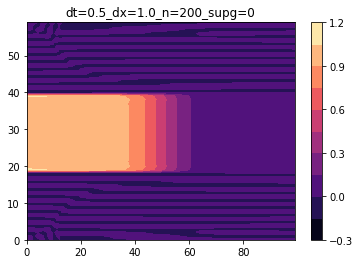

In [36]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=200, 
    dx=1.0,
    supg=False, 
    save=True, 
    video=False
)

### n = 400:

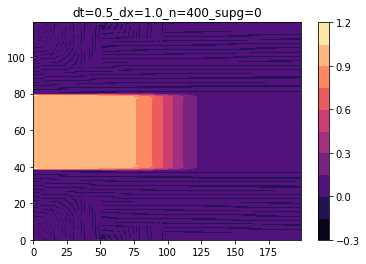

In [5]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=400, 
    dx=1.0,
    supg=False, 
    save=True, 
    video=False
)

### n = 800:

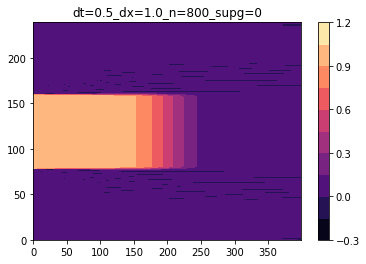

In [6]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=800, 
    dx=1.0,
    supg=False, 
    save=True, 
    video=False
)

## $d_{x}$ = 0.0001:

### n = 200:

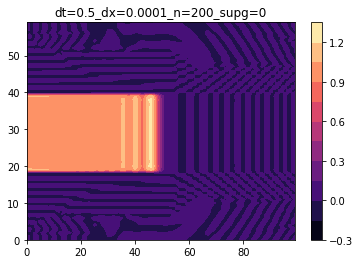

In [7]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=200, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

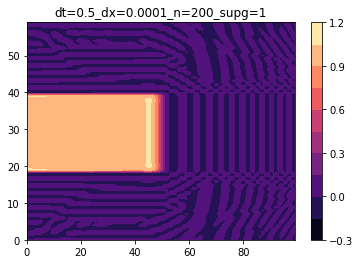

In [8]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=200, 
    dx=0.0001,
    supg=True, 
    save=True, 
    video=False
)

### n = 400:

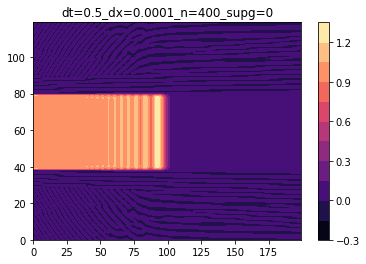

In [9]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

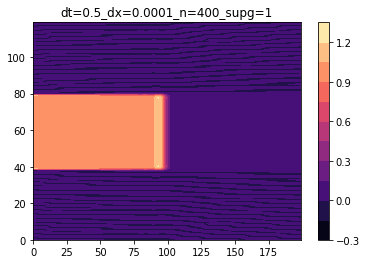

In [10]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=400, 
    dx=0.0001,
    supg=True, 
    save=True, 
    video=False
)

### n = 800:

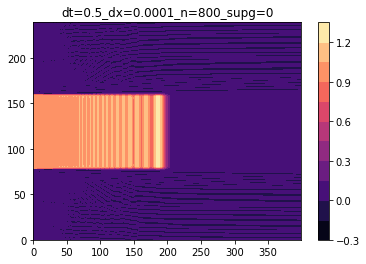

In [11]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=800, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

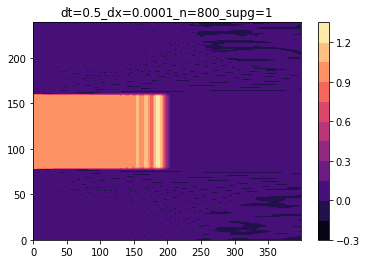

In [12]:
actor = Act()
actor.act_plot(
    solver=NCDE,
    T=100,
    n=800, 
    dx=0.0001,
    supg=True, 
    save=True, 
    video=False
)

## Let's check stability related to "dt":

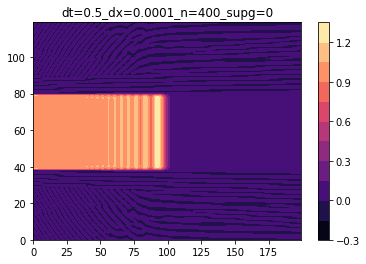

In [13]:
T = 100

actor = Act()
actor.act_plot(
    solver=NCDE,
    T=T,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

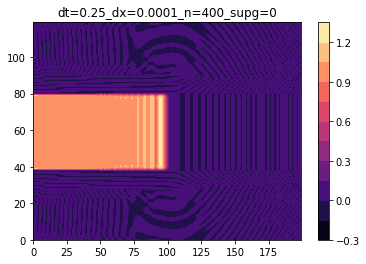

In [14]:
T = 200

actor = Act()
actor.act_plot(
    solver=NCDE,
    T=T,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

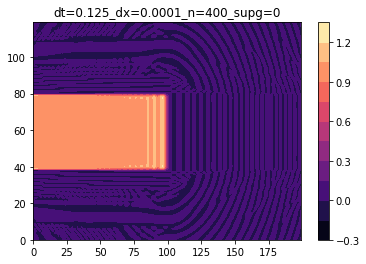

In [15]:
T = 400

actor = Act()
actor.act_plot(
    solver=NCDE,
    T=T,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

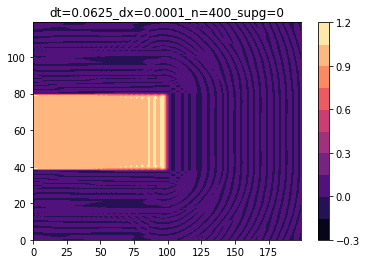

In [16]:
T = 800

actor = Act()
actor.act_plot(
    solver=NCDE,
    T=T,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)

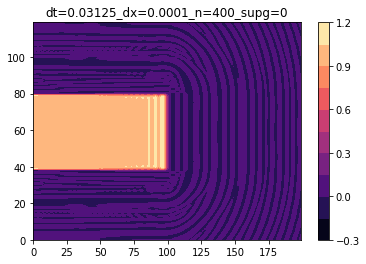

In [17]:
T = 1600

actor = Act()
actor.act_plot(
    solver=NCDE,
    T=T,
    n=400, 
    dx=0.0001,
    supg=False, 
    save=True, 
    video=False
)